In [1]:
# This program utilizes a recurrent neural network (Long Short-term Memory) to analyze and predict future

# Libraries
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from cryptocmd import CmcScraper
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [2]:
# Retrieve data from CoinMarketCap

crypto = 'BTC'

scraper = CmcScraper(crypto)

df = scraper.get_dataframe()

df = df.iloc[::-1]

df

,Date,Open,High,Low,Close,Volume,Market Cap
3662,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
3661,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
3660,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3659,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
3658,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4,2023-05-04,29031.304448,29353.184660,28694.039025,28847.711591,1.554868e+10,5.586172e+11
3,2023-05-05,28851.479662,29668.907677,28845.510534,29534.384020,1.793657e+10,5.719354e+11
2,2023-05-06,29538.859005,29820.126622,28468.967410,28904.623949,1.591387e+10,5.597675e+11
1,2023-05-07,28901.622824,29157.518185,28441.368038,28454.978286,1.130136e+10,5.510833e+11


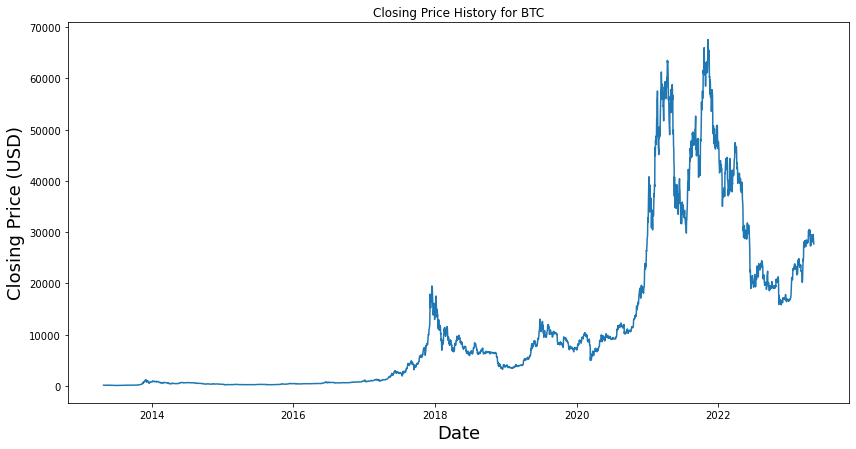

In [3]:
# create a graph of closing prices of select cryptocurrency
plt.figure(figsize=(14, 7))
plt.title('Closing Price History for ' + crypto)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (USD)', fontsize=18)
plt.plot(df['Date'].values, df['Close'].values)
plt.show()

In [4]:
# Prepare training data

data = df.filter(['Close'])

dataset = data.values

training_data_len = math.ceil(len(dataset)*0.8)

min_max_scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = min_max_scaler.fit_transform(dataset)

training_data = scaled_data[0:training_data_len, :]

prediction_period = 60

x_train = []
y_train = []

for i in range(prediction_period, len(training_data)):
    x_train.append(training_data[i-prediction_period:i, 0])
    y_train.append(training_data[i, 0])

x_train, y_train= np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


(2871, 60, 1)

In [5]:
# prepare testing data

test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_test.shape

(732, 60, 1)

In [6]:
# Create LSTM Model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [7]:
# Compile and Train the model

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=16)


Epoch 1/16
90/90 [==============================] - 7s 32ms/step - loss: 0.0019
Epoch 2/16
90/90 [==============================] - 3s 31ms/step - loss: 4.1846e-04
Epoch 3/16
90/90 [==============================] - 3s 31ms/step - loss: 3.1361e-04
Epoch 4/16
90/90 [==============================] - 3s 31ms/step - loss: 3.1163e-04
Epoch 5/16
90/90 [==============================] - 3s 33ms/step - loss: 3.3343e-04
Epoch 6/16
90/90 [==============================] - 3s 31ms/step - loss: 2.4897e-04
Epoch 7/16
90/90 [==============================] - 3s 31ms/step - loss: 2.1502e-04
Epoch 8/16
90/90 [==============================] - 3s 31ms/step - loss: 2.4263e-04
Epoch 9/16
90/90 [==============================] - 3s 31ms/step - loss: 1.9988e-04
Epoch 10/16
90/90 [==============================] - 3s 32ms/step - loss: 1.5563e-04
Epoch 11/16
90/90 [==============================] - 3s 32ms/step - loss: 1.3898e-04
Epoch 12/16
90/90 [==============================] - 3s 32ms/step - loss: 1.49

In [8]:
# Get model predicted values

model_predictions = model.predict(x_test)
model_predictions = min_max_scaler.inverse_transform(model_predictions)

23/23 [==============================] - 1s 10ms/step


In [9]:
# Get root mean squared error

testing_score = np.sqrt(np.mean(model_predictions - y_test)**2)
testing_score

1127.3793006456992

<function matplotlib.pyplot.show(close=None, block=None)>

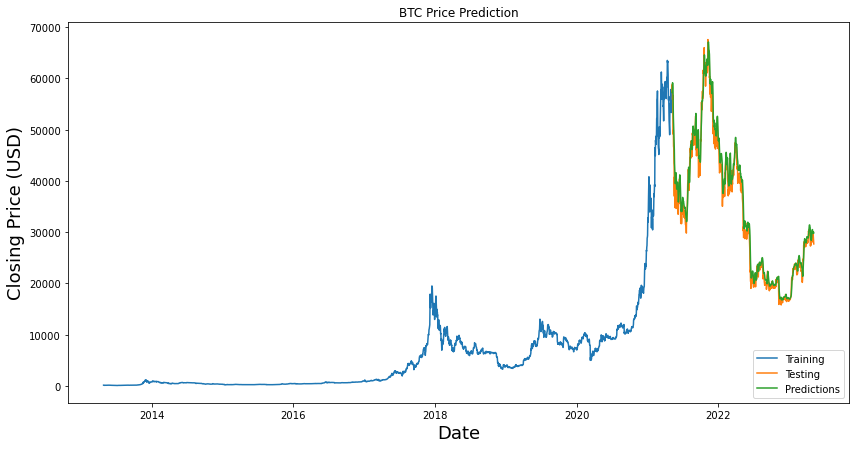

In [10]:
# Plot data

training_values = dataset[:training_data_len]
test_values = dataset[training_data_len:]

# Create graph

plt.figure(figsize=(14,7))
plt.title(crypto + ' Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (USD)', fontsize=18)
plt.plot(df['Date'].values[:training_data_len], training_values)
plt.plot(df['Date'].values[training_data_len:], test_values)
plt.plot(df['Date'].values[training_data_len:], model_predictions)
plt.legend(['Training', 'Testing', 'Predictions'], loc = 'lower right')
plt.show

In [11]:
# Show Predicted prices
prediction_data = pd.DataFrame()
prediction_data['Date'] = df['Date'].values[training_data_len:]
prediction_data['Testing'] = test_values
prediction_data['Predictions'] = model_predictions

prediction_data


,Date,Testing,Predictions
0,2021-05-07,57356.401877,57261.496094
1,2021-05-08,58803.775809,57634.257812
2,2021-05-09,58232.316142,58559.781250
3,2021-05-10,55859.797545,59134.109375
4,2021-05-11,56704.573058,58521.335938
...,...,...,...
727,2023-05-04,28847.711591,29835.291016
728,2023-05-05,29534.384020,29794.185547
729,2023-05-06,28904.623949,29982.103516
730,2023-05-07,28454.978286,30012.871094
